# Evaluate proposed drift-seq gene sets for quality

Tong Shu Li

Michael has prepared some gene sets for resequencing. Here we will evaluate how good these gene sets are at capturing drift. They will be compared to the size-matched background reference like the GO terms.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import warnings

from scipy.stats import percentileofscore
from tqdm import tqdm

sys.path.append("../..")

from src.drift import calc_drift
from src.plots import config_plot
from src.fit_model import fit_model

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

---

## Read the prepared drift seq gene sets

In [3]:
seq_sets = pd.read_csv("../../data/PMID26623667/raw/drift_seq_sets_20160628.tsv", sep = '\t')

In [4]:
seq_sets.shape

(299, 4)

In [5]:
seq_sets.head()

set_name     wormbase_id gene_symbol   seqname
0  control  WBGene00001022       dnj-4   C01G8.4
1  control  WBGene00010803    M01B2.10  M01B2.10
2  control  WBGene00019326     K02F3.2   K02F3.2
3  control  WBGene00002299      let-23  ZK1067.1
4  control  WBGene00011920    T22C1.11  T22C1.11

## Number of gene sets

In [6]:
seq_sets["set_name"].nunique()

16

## Number of genes per gene set

In [7]:
seq_sets["set_name"].value_counts()

defense response to bacterium                  27
cellular lipid metabolism                      25
Organelle(ER)                                  21
response to topologically incorrect protein    20
oxidative phosphroylation                      20
glycolisis                                     20
TCA                                            20
Organelle(golgi)                               20
Organelle(lysosome)                            20
Other(locomotion)                              20
response to radiation                          19
Organelle(mitochondria)                        18
Organelle(nucleus)                             16
Other(proteasome)                              13
control                                        10
Other(penthosephosphate)                       10
Name: set_name, dtype: int64

In [8]:
seq_sets["wormbase_id"].nunique()

284

---

## Read PMID26623667 original data

In [9]:
exp = (pd
    .read_csv("../../data/PMID26623667/clean_annotated_cpm_values.tsv", sep = '\t')
    .query("cohort <= 7 & samples != 62")
    .assign(log_day = lambda df: np.log(df["day_harvested"]))
    .rename(columns = {"wormbaseid": "wormbase_id", "cohort": "sample"})
    .replace("water", "control")
)

## Fit log-linear models for each gene set

In [10]:
def get_drift(gene_set):
    sub = exp.query("wormbase_id in @gene_set")
    
    return calc_drift(sub, ['sample', 'replicate', 'drug', 'day_harvested', 'log_day'], 'RLFEC')

In [11]:
models = []
for name, df in seq_sets.groupby("set_name"):
    genes = set(df["wormbase_id"])
    drift = get_drift(genes)
    
    models.append(
        fit_model(drift, "log_linear", False)
            .assign(set_name = name)
    )
    
models = pd.concat(models).reset_index(drop = True)

In [12]:
models.head()

parameter  estimate  std_error   t_value       p_value   adj_rsq  \
0         (Intercept) -0.101382   0.104832 -0.967092  3.470558e-01  0.827102   
1  log(day_harvested)  0.637877   0.066879  9.537759  3.084129e-08  0.827102   
2       drugmianserin -0.409346   0.103617 -3.950548  1.032109e-03  0.827102   
3         (Intercept)  0.050066   0.047167  1.061466  3.033259e-01  0.733934   
4  log(day_harvested)  0.207093   0.030091  6.882215  2.656707e-06  0.733934   

   anova_pvalue interaction       model          set_name  
0      0.487072       False  log_linear     Organelle(ER)  
1      0.487072       False  log_linear     Organelle(ER)  
2      0.487072       False  log_linear     Organelle(ER)  
3      0.688571       False  log_linear  Organelle(golgi)  
4      0.688571       False  log_linear  Organelle(golgi)

---

## Compare models to random background distribution

In [13]:
info = (seq_sets["set_name"]
    .value_counts()
    .to_frame("num_genes")
    .reset_index()
    .rename(columns = {"index": "set_name"})
    .merge(
        models[["set_name", "adj_rsq"]].drop_duplicates(),
        how = "left", on = "set_name"
    )
    .sort_values(["num_genes", "set_name"], ascending = [False, True])
)

info

set_name  num_genes   adj_rsq
0                 defense response to bacterium         27  0.904612
1                     cellular lipid metabolism         25  0.704685
2                                 Organelle(ER)         21  0.827102
7                              Organelle(golgi)         20  0.733934
8                           Organelle(lysosome)         20  0.723890
9                             Other(locomotion)         20  0.637211
6                                           TCA         20  0.737247
5                                    glycolisis         20  0.490875
4                     oxidative phosphroylation         20  0.745530
3   response to topologically incorrect protein         20  0.914442
10                        response to radiation         19  0.726304
11                      Organelle(mitochondria)         18  0.411368
12                           Organelle(nucleus)         16  0.691021
13                            Other(proteasome)         13  0.131118
15                     Other(penthosephosphate)         10  0.488176
14                                      control         10  0.113317

## Prepare the background distributions

Since our gene sets only go up to 27 genes, we will only need to read the gene sets of up to size 30.

In [14]:
def read(set_size):
    """Read models for the background distribution of a specific size
    of gene set.
    """
    floc = "../../data/PMID26623667/rand_sampling/models/size_{}.model".format(set_size)
    return (pd
        .read_csv(floc, sep = '\t')
        .query("model == 'loglinear' & ~interaction")
    )

In [15]:
def reshape(model, id_col):
    """Reshape the model information dataframe.
    
    Expects the raw output of read() as input.    
    """
    
    info = (model
        .assign(error_percent = lambda df: np.abs(df['std_error'] / df['estimate']) * 100)
        [[id_col, "parameter", "estimate", "std_error", "p_value", "error_percent"]]
        .query("parameter != '(Intercept)'")
        .replace(
            {
                "drugmianserin": "mianserin",
                "log(day_harvested)": "log_day"
            }
        )
    )
    
    return pd.melt(info, id_vars = [id_col, "parameter"])

In [16]:
def process_ref():
    """Read the model information for the background reference distributions."""
    
    num_min = 10
    num_max = 30
    step = 10

    rsq_res = []
    parameters = []
    for i in tqdm(range(num_min, num_max+step, step)):
        chunk = read(i)
        
        params = reshape(chunk, "uid")
        parameters.append(params.assign(set_size = i))

        rsq = (chunk
            [["uid", "adj_rsq"]]
            .drop_duplicates()
            .assign(set_size = i)
        )

        rsq_res.append(rsq)
        
    rsq_res = pd.concat(rsq_res).reset_index(drop = True)
    parameters = pd.concat(parameters).reset_index(drop = True)
    
    return (rsq_res, parameters)

In [17]:
ref_rsq, ref_params = process_ref()

100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


## Calculate the adjusted R-squared percentile value

In [18]:
def percentileof(values, score):
    """Adjusted percentile function. Modifies the maximum possible
    percentile value from 100.0% to 100% - epsilon, where epsilon is
    1/len(values).
    
    Output range: [0, 100)
    """
    res = percentileofscore(values, score)
    return res - 1/len(values) if res == 100 else res

In [19]:
def calc_nlpval(percentile, direction = 1):
    """Given a percentile value from [0, 100),
    calculates the corresponding -log(p value).
    
    Direction can be set to decide whether small or large
    percentile values correspond to small p values.
    
    direction = 1 means a percentile near 100 equates to a 
    p value near 0
    
    direction = 0 means a percentile near 0 equates to a p
    value near 0
    """
    assert direction == 0 or direction == 1
    
    pile = percentile / 100
    pile = 1 - pile if direction == 1 else pile
    
    return -np.log10(pile)

In [20]:
cache = {size: df['adj_rsq'] for size, df in ref_rsq.groupby("set_size")}

def percentile(num_genes, adj_rsq):
    # round to nearest 10
    closest = round(num_genes, -1)
    
    return percentileof(cache[closest], adj_rsq)

info["rsq_pile"] = (info
    [["num_genes", "adj_rsq"]]
    .apply(lambda row: percentile(*row), axis = 1)
)

info["rsq_pval"] = 1 - info["rsq_pile"] / 100

In [21]:
info

set_name  num_genes   adj_rsq  \
0                 defense response to bacterium         27  0.904612   
1                     cellular lipid metabolism         25  0.704685   
2                                 Organelle(ER)         21  0.827102   
7                              Organelle(golgi)         20  0.733934   
8                           Organelle(lysosome)         20  0.723890   
9                             Other(locomotion)         20  0.637211   
6                                           TCA         20  0.737247   
5                                    glycolisis         20  0.490875   
4                     oxidative phosphroylation         20  0.745530   
3   response to topologically incorrect protein         20  0.914442   
10                        response to radiation         19  0.726304   
11                      Organelle(mitochondria)         18  0.411368   
12                           Organelle(nucleus)         16  0.691021   
13                            Other(proteasome)         13  0.131118   
15                     Other(penthosephosphate)         10  0.488176   
14                                      control         10  0.113317   

    rsq_pile  rsq_pval  
0      90.95    0.0905  
1      37.27    0.6273  
2      73.03    0.2697  
7      44.83    0.5517  
8      42.15    0.5785  
9      24.15    0.7585  
6      45.79    0.5421  
5       8.97    0.9103  
4      48.24    0.5176  
3      96.01    0.0399  
10     42.80    0.5720  
11      5.02    0.9498  
12     33.92    0.6608  
13      3.83    0.9617  
15     28.57    0.7143  
14      3.23    0.9677

## Model parameter scoring

In [22]:
model_params = (reshape(models, "set_name")
    .merge(info[["set_name", "num_genes"]], how = "left", on = "set_name")
)

cache = dict()
for (size, param, var), df in ref_params.groupby(["set_size", "parameter", "variable"]):
    cache[(size, param, var)] = df["value"]

def calc_percentile(num_genes, parameter, variable, value):
    # round to nearest 10
    closest = round(num_genes, -1)
    
    ref_vals = cache[(closest, parameter, variable)]
    return percentileof(ref_vals, value)

model_params["percentile"] = (model_params
    [["num_genes", "parameter", "variable", "value"]]
    .apply(lambda row: calc_percentile(*row), axis = 1)
)

In [23]:
model_params.head()

set_name  parameter  variable     value  num_genes  percentile
0        Organelle(ER)    log_day  estimate  0.637877         21       92.72
1        Organelle(ER)  mianserin  estimate -0.409346         21       30.75
2     Organelle(golgi)    log_day  estimate  0.207093         20       20.20
3     Organelle(golgi)  mianserin  estimate -0.207045         20       76.23
4  Organelle(lysosome)    log_day  estimate  0.525622         20       86.47

## Calculate final score

The final score is again the sum of the negative logarithm of the percentiles. We are only using the percentile values of the adjusted R-squared, and the estimates of the time and treatment effect. Experience has shown that the other variables make score interpretation more complicated.

In [24]:
def rearrange(df):
    res = dict()
    
    name = {
        "estimate": "est",
        "std_error": "error",
        "p_value": "pval",
        "error_percent": "error_percent"
    }
    
    for (param, variable), sub in df.groupby(["parameter", "variable"]):
        temp = sub.iloc[0]
        
        res["{}_{}".format(param, name[variable])] = temp['value']
        
        if variable == 'estimate':
            res["{}_{}_pile".format(param, name[variable])] = temp['percentile']
        
    return pd.Series(res)

In [25]:
final = (info
    .merge(
        model_params.groupby("set_name").apply(rearrange).reset_index(),
        how = "left", on = "set_name"
    )
)

In [26]:
final.head()

set_name  num_genes   adj_rsq  rsq_pile  rsq_pval  \
0  defense response to bacterium         27  0.904612     90.95    0.0905   
1      cellular lipid metabolism         25  0.704685     37.27    0.6273   
2                  Organelle(ER)         21  0.827102     73.03    0.2697   
3               Organelle(golgi)         20  0.733934     44.83    0.5517   
4            Organelle(lysosome)         20  0.723890     42.15    0.5785   

   log_day_error  log_day_error_percent  log_day_est  log_day_est_pile  \
0       0.155251               7.425212     2.090858           99.9999   
1       0.055534              15.227760     0.364692           64.3400   
2       0.066879              10.484643     0.637877           92.7200   
3       0.030091              14.530205     0.207093           20.2000   
4       0.073071              13.901796     0.525622           86.4700   

   log_day_pval  mianserin_error  mianserin_error_percent  mianserin_est  \
0  1.689689e-10         0.240534                21.928364      -1.096907   
1  4.794272e-06         0.086041                26.484005      -0.324879   
2  3.084129e-08         0.103617                25.312941      -0.409346   
3  2.656707e-06         0.046621                22.517182      -0.207045   
4  1.503528e-06         0.113211                58.122187      -0.194780   

   mianserin_est_pile  mianserin_pval  
0                0.11        0.000278  
1               47.70        0.001508  
2               30.75        0.001032  
3               76.23        0.000358  
4               78.97        0.103488

In [27]:
def score(**row):
    # use log(1 - value) when larger values are better
    # use log(value) when smaller values are better
    
    return (calc_nlpval(row["rsq_pile"])
        + calc_nlpval(row["log_day_est_pile"])
        + calc_nlpval(row["mianserin_est_pile"], direction = 0)
    )

final["score"] = final.apply(lambda r: score(**r), axis = 1)

In [28]:
final.shape

(16, 16)

In [29]:
final.sort_values("score", ascending = False)

set_name  num_genes   adj_rsq  \
0                 defense response to bacterium         27  0.904612   
9   response to topologically incorrect protein         20  0.914442   
2                                 Organelle(ER)         21  0.827102   
4                           Organelle(lysosome)         20  0.723890   
14                     Other(penthosephosphate)         10  0.488176   
1                     cellular lipid metabolism         25  0.704685   
5                             Other(locomotion)         20  0.637211   
12                           Organelle(nucleus)         16  0.691021   
3                              Organelle(golgi)         20  0.733934   
10                        response to radiation         19  0.726304   
7                                    glycolisis         20  0.490875   
8                     oxidative phosphroylation         20  0.745530   
6                                           TCA         20  0.737247   
13                            Other(proteasome)         13  0.131118   
15                                      control         10  0.113317   
11                      Organelle(mitochondria)         18  0.411368   

    rsq_pile  rsq_pval  log_day_error  log_day_error_percent  log_day_est  \
0      90.95    0.0905       0.155251               7.425212     2.090858   
9      96.01    0.0399       0.111146               7.402212     1.501523   
2      73.03    0.2697       0.066879              10.484643     0.637877   
4      42.15    0.5785       0.073071              13.901796     0.525622   
14     28.57    0.7143       0.084737              25.639694     0.330493   
1      37.27    0.6273       0.055534              15.227760     0.364692   
5      24.15    0.7585       0.057411              20.629724     0.278295   
12     33.92    0.6608       0.042557              15.316964     0.277845   
3      44.83    0.5517       0.030091              14.530205     0.207093   
10     42.80    0.5720       0.029158              14.883114     0.195911   
7       8.97    0.9103       0.050198              26.751810     0.187644   
8      48.24    0.5176       0.010089              14.247506     0.070814   
6      45.79    0.5421       0.010019              14.009609     0.071516   
13      3.83    0.9617       0.015847              54.100547     0.029293   
15      3.23    0.9677       0.011102              47.543880     0.023351   
11      5.02    0.9498       0.013898              26.130648     0.053186   

    log_day_est_pile  log_day_pval  mianserin_error  mianserin_error_percent  \
0            99.9999  1.689689e-10         0.240534                21.928364   
9            99.9300  1.609745e-10         0.172201                12.084383   
2            92.7200  3.084129e-08         0.103617                25.312941   
4            86.4700  1.503528e-06         0.113211                58.122187   
14           59.7000  1.151189e-03         0.131286                31.238611   
1            64.3400  4.794272e-06         0.086041                26.484005   
5            41.6200  1.509856e-04         0.088949                21.533656   
12           41.5100  5.154960e-06         0.065935                32.194737   
3            20.2000  2.656707e-06         0.046621                22.517182   
10           16.9500  3.600147e-06         0.045175                22.535681   
7            15.0100  1.636798e-03         0.077773                29.001047   
8             0.3500  2.065942e-06         0.015632                21.216301   
6             0.3500  1.662214e-06         0.015523                25.209152   
13            0.7100  8.201451e-02         0.024553                60.046382   
15            0.5300  5.063331e-02         0.017201               194.290705   
11            0.0700  1.349613e-03         0.021532                55.092169   

    mianserin_est  mianserin_est_pile  mianserin_pval      score  
0       -1.096907                0.11    2.775869e-04  10.001959  
9       -

Most of the gene sets scored quite poorly, meaning they had models which fit no better than what we would expect if we picked gene sets randomly.

## Plot results

What are the drift plots like for each gene set?

In [30]:
def examine(name, gene_set):
    sub = exp.query("wormbase_id in @gene_set")
    
    drift = calc_drift(sub, ["sample", "replicate", "drug", "day_harvested", "log_day"], "RLFEC")

    return sns.lmplot(
        data = drift,
        x = "log_day", y = "drift",
        hue = "drug", size = 9,
        markers = ['o', 'x']
    )

100%|██████████| 16/16 [00:07<00:00,  1.99it/s]


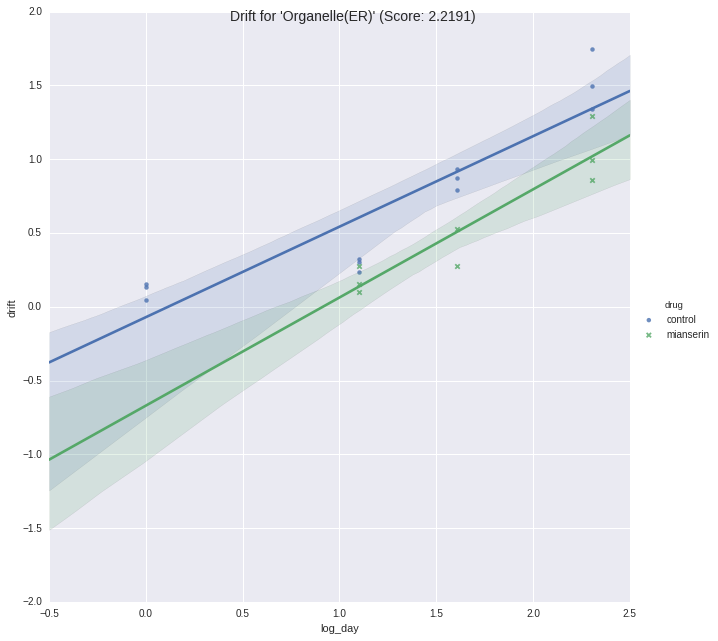

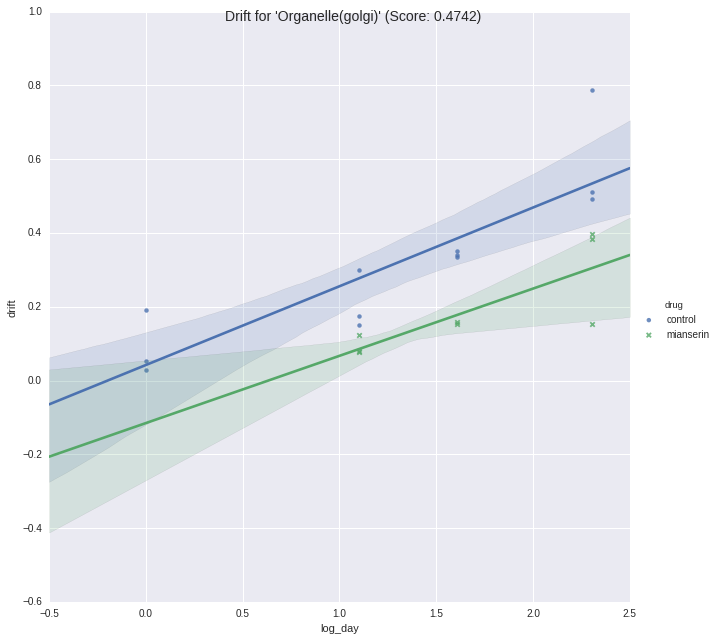

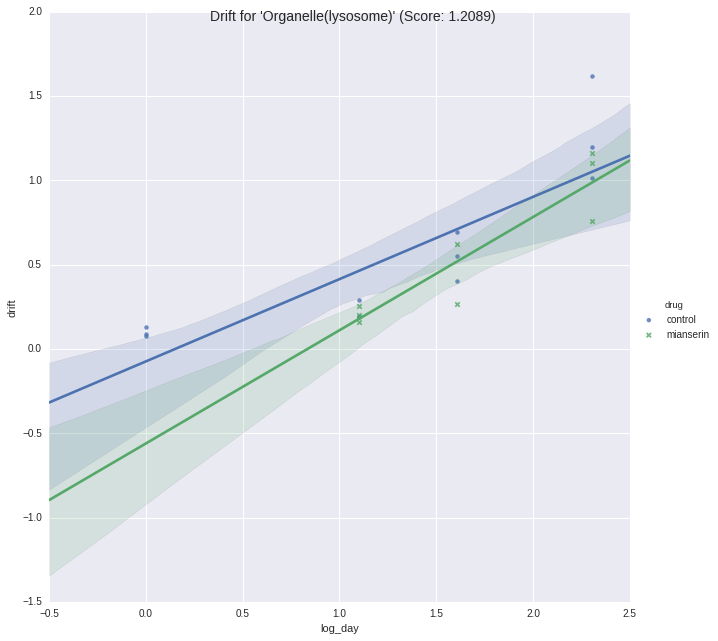

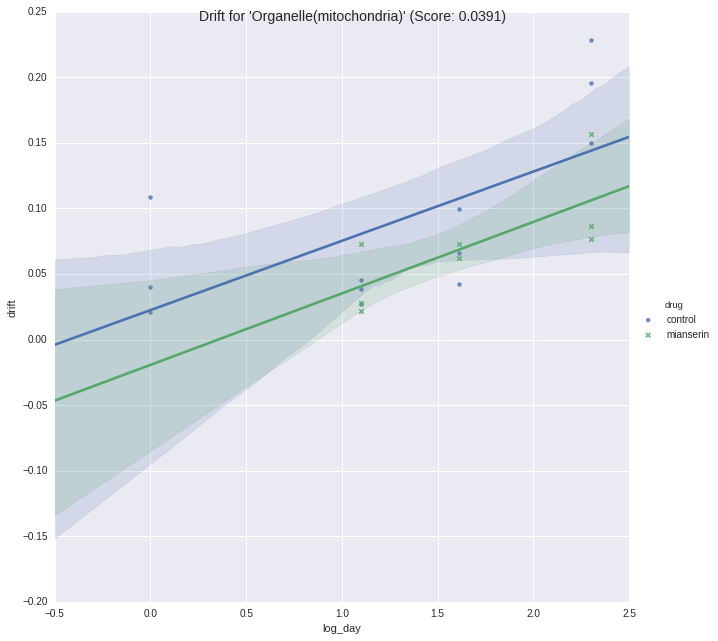

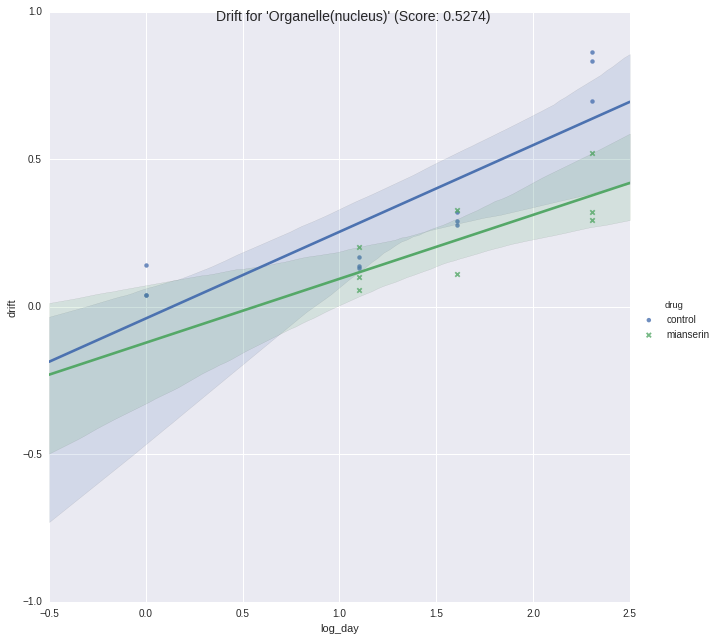

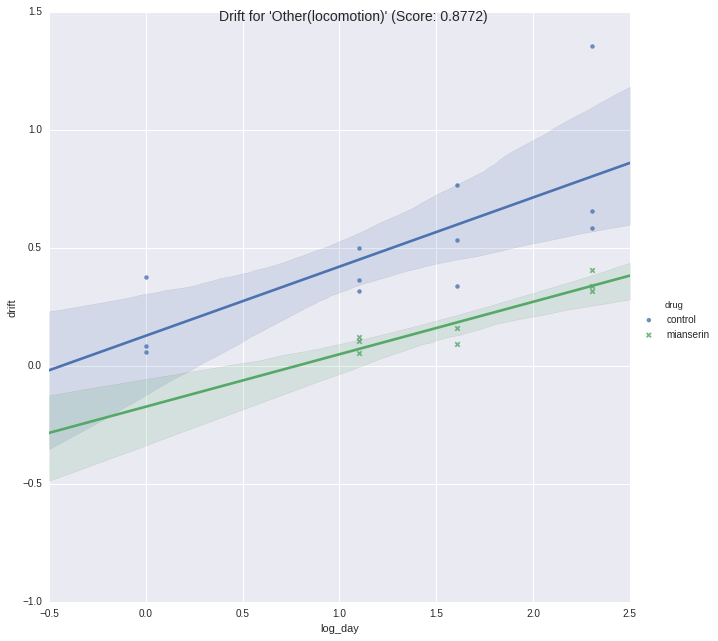

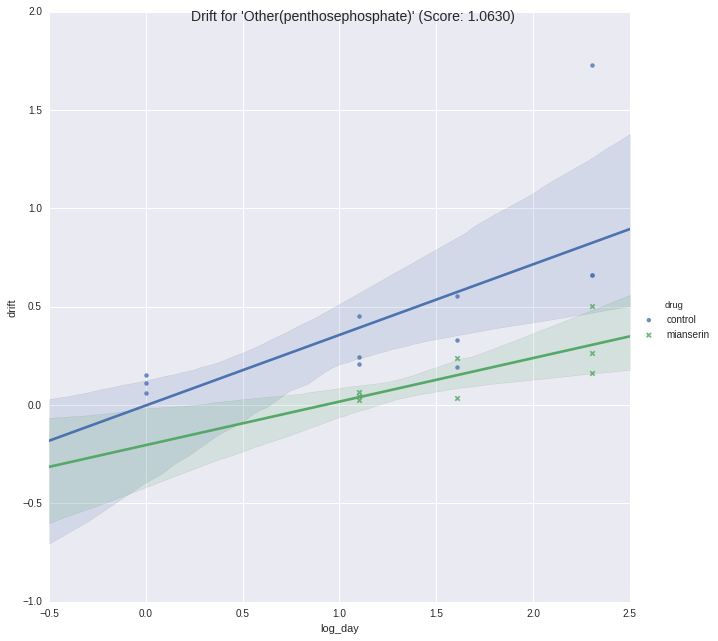

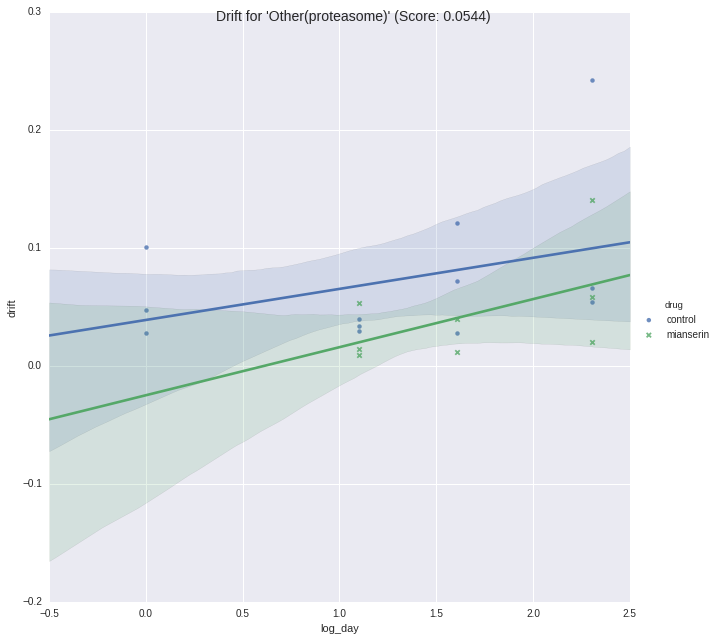

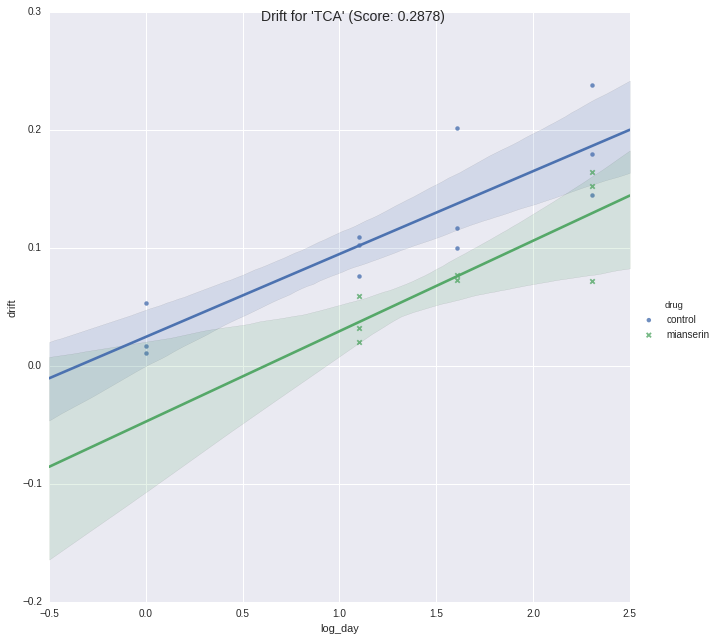

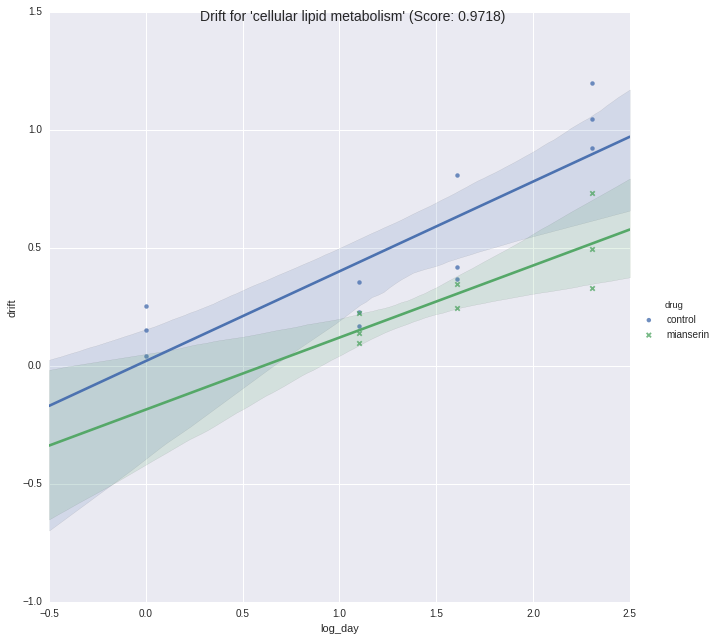

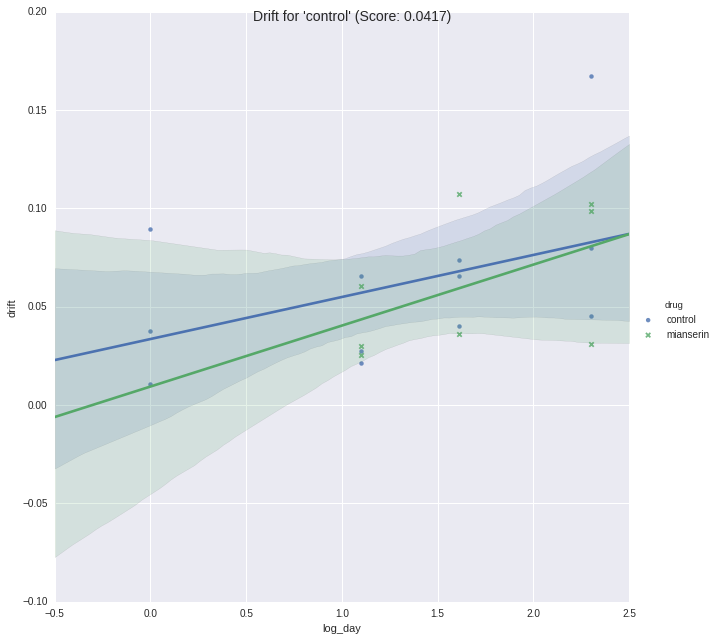

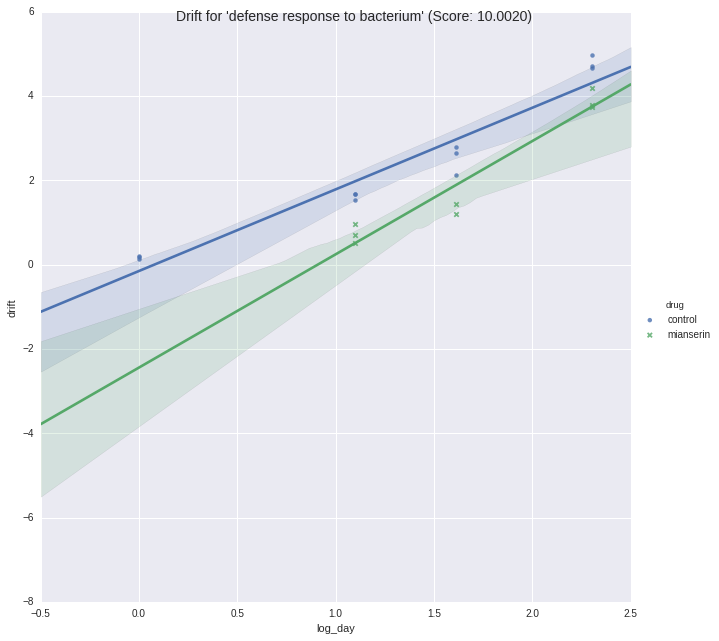

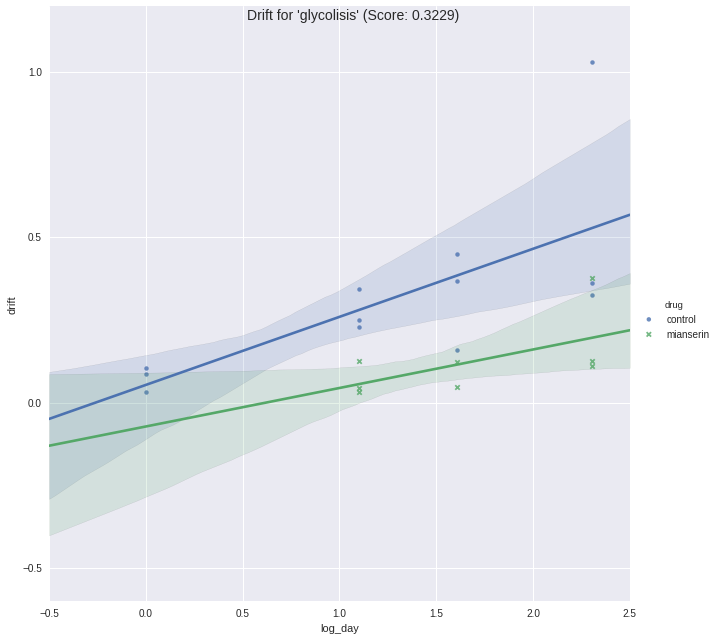

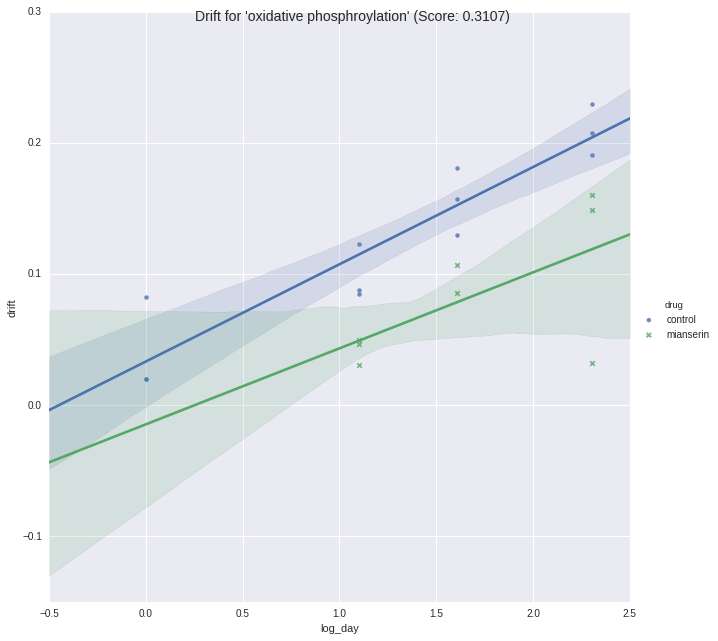

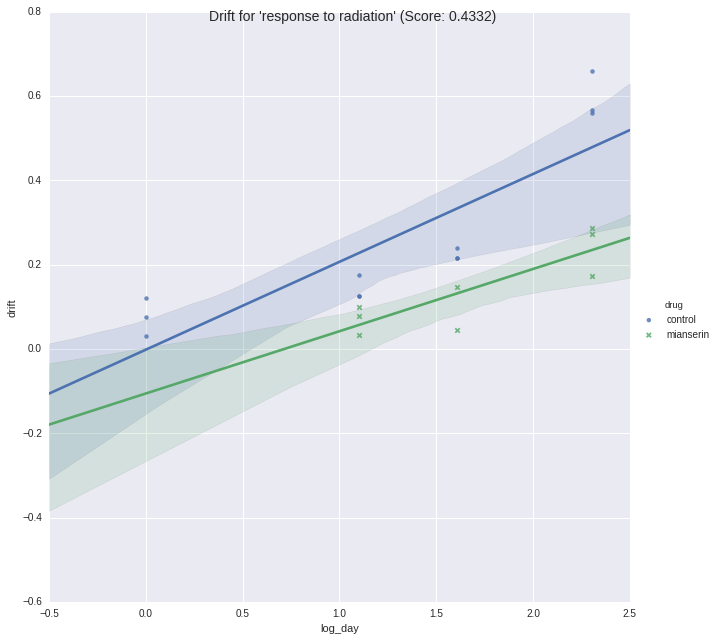

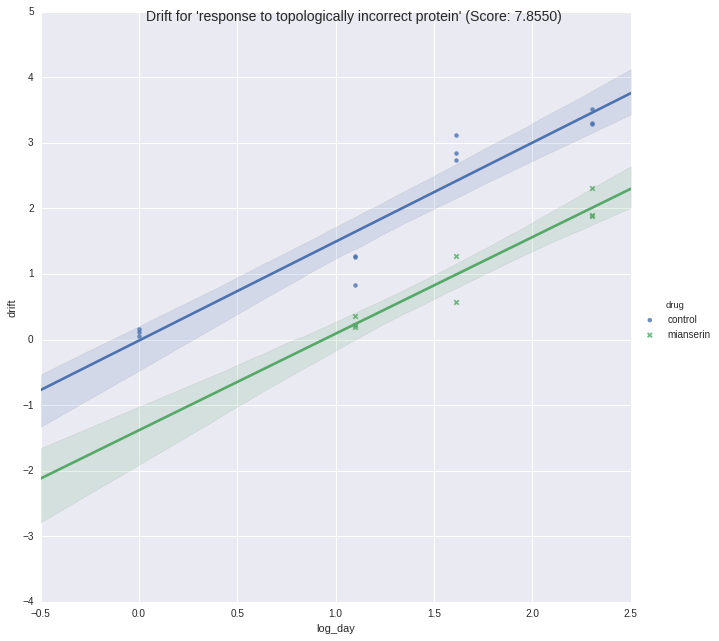

In [31]:
for name, df in tqdm(seq_sets.groupby("set_name")):
    genes = set(df["wormbase_id"])
    
    g = examine(name, genes)
    
    score = final.query("set_name == @name")["score"].iloc[0]
    
    g.fig.suptitle("Drift for '{}' (Score: {:.4f})".format(name, score), fontsize = 14);

---

## Plot the RLFEC values for the individual genes

In [32]:
def lineplot(data, time_col, unit_col, val_col, cond_col, ax):
    # when using different numbers of replicates per sample,
    # the default np.mean estimator will give a nan value
    # since some things are missing
    # the nans are not plotted, giving an empty plot
    
    # the default solution is to use estimator = scipy.stats.nanmean,
    # as per (http://stackoverflow.com/questions/29156464/seaborn-tsplot-not-showing-ci-bands),
    # but the function is deprecated
    # the preferred nanmean function is numpy.nanmean
    
    # however using np.nanmean will give lots of warnings
    # so we just ignore any warnings (no warnings given by scipy.stats.nanmean)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        return sns.tsplot(
            data = data,
            time = time_col, unit = unit_col,
            value = val_col, condition = cond_col,
            estimator = np.nanmean,
            ax = ax
        )

In [33]:
def summary(gset_name, data, time_col, unit_col, val_col, cond_col):
    fig, ax = plt.subplots(
        nrows = 2, figsize = (10, 10),
        sharey = True
    )

    minx = data[time_col].min()
    maxx = data[time_col].max()

    for axis, group in zip(ax, ["control", "mianserin"]):
        axis = lineplot(
            data.query("drug == @group"),
            time_col, unit_col,
            val_col, cond_col,
            axis
        )
        
        axis.set_title("RLFEC for gene set '{}' ({})".format(gset_name, group))
        axis.set_xlim((minx, maxx))
        
        if group == "control":
            axis.legend(loc = "upper left", bbox_to_anchor = (1, 0.5))
        else:
            axis.legend_.remove()
    
    return axis

100%|██████████| 16/16 [03:27<00:00, 13.37s/it]


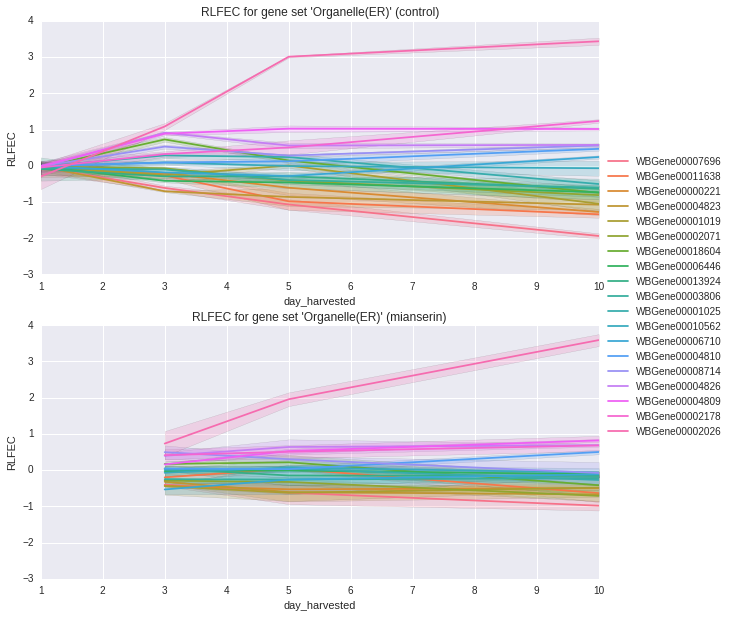

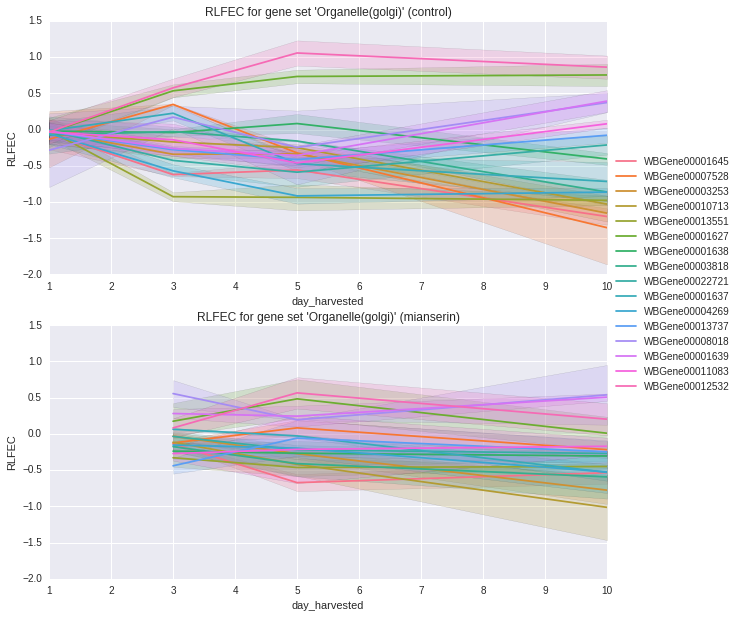

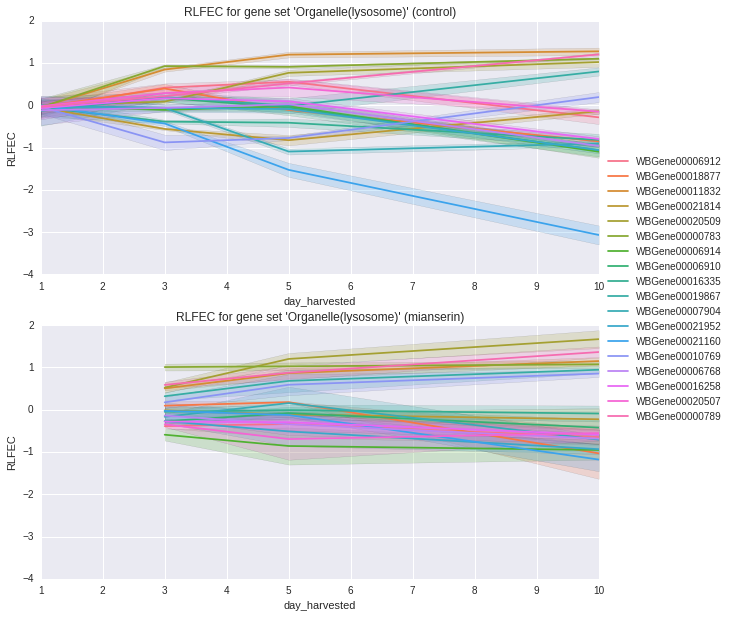

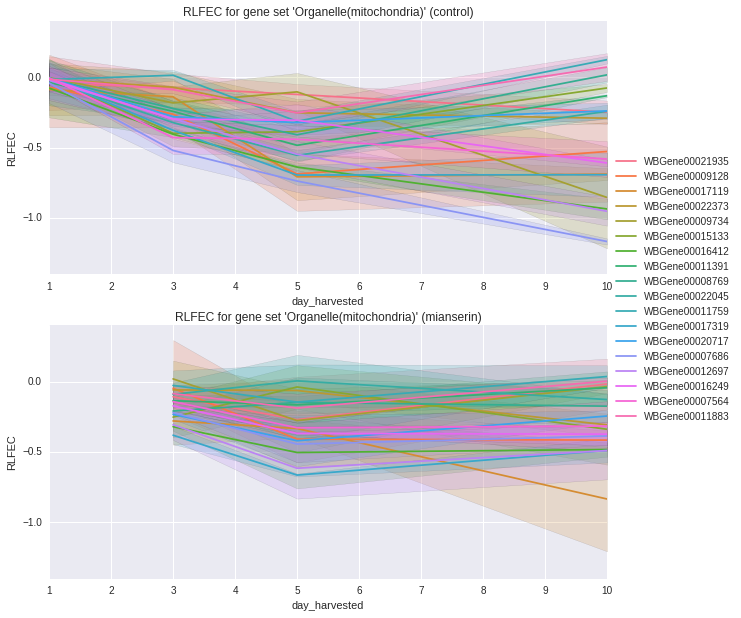

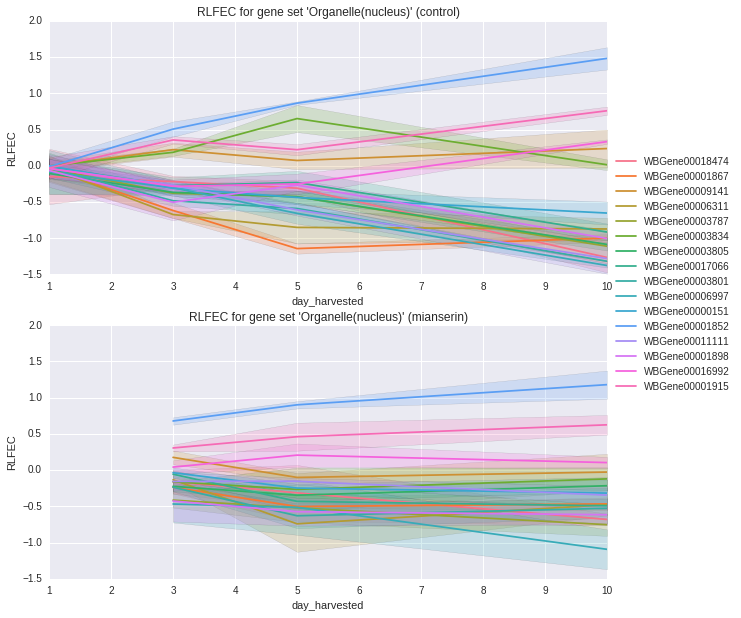

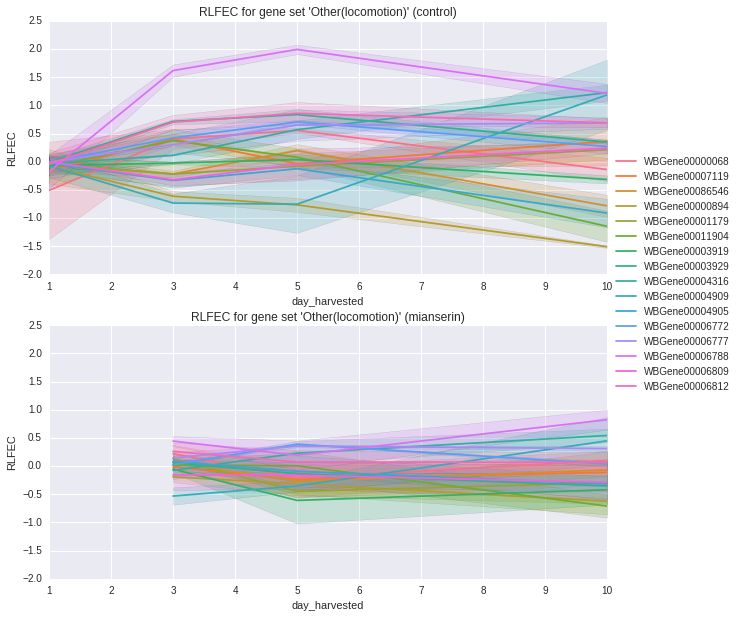

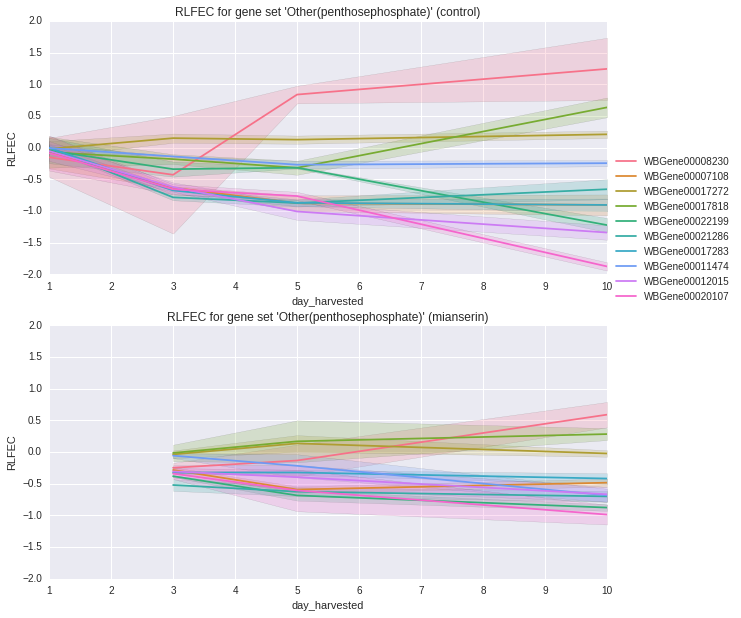

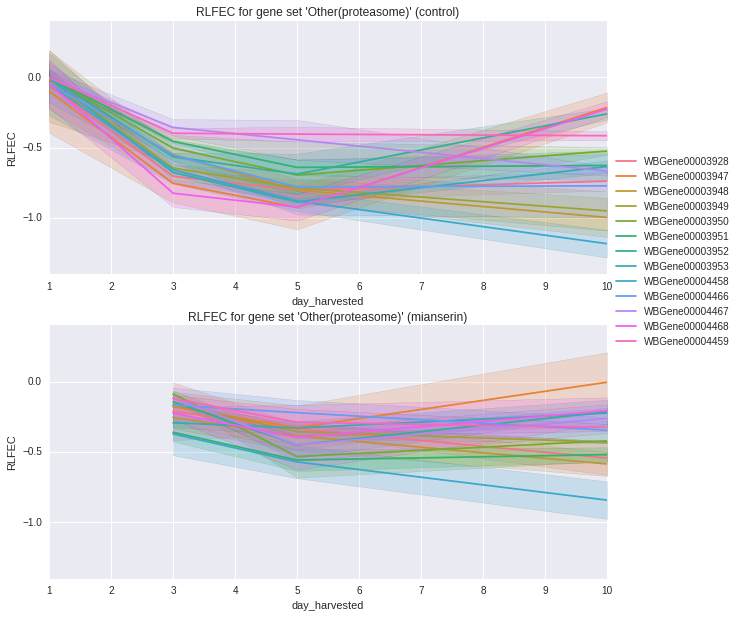

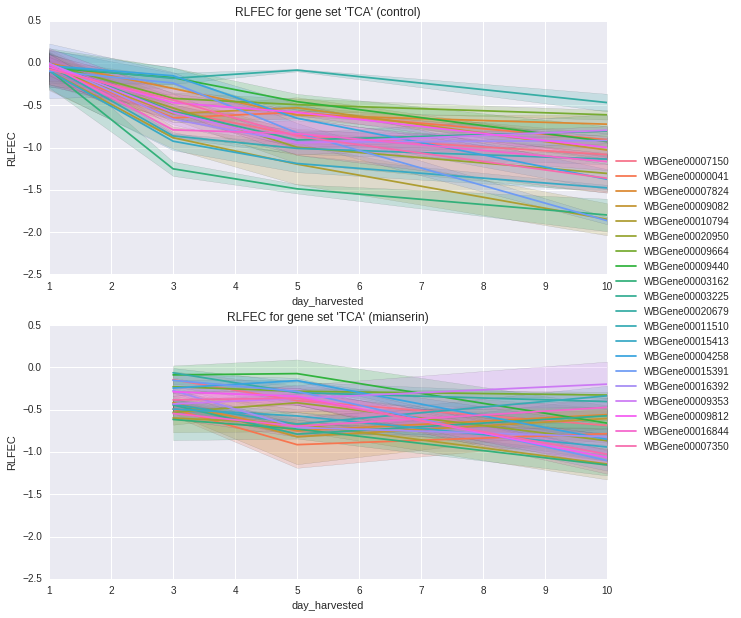

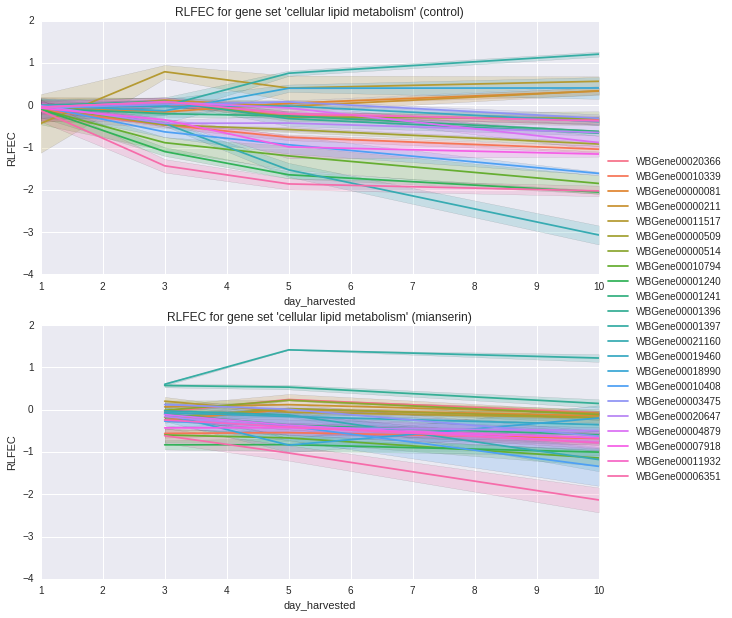

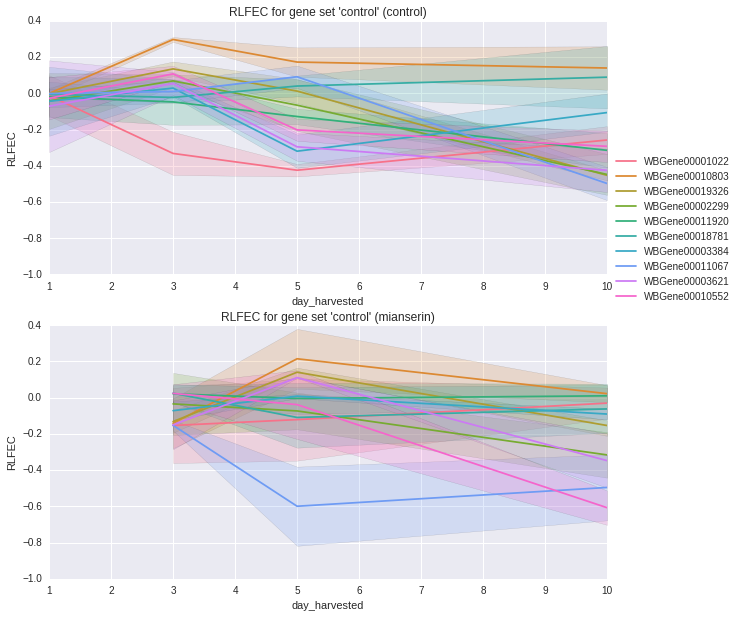

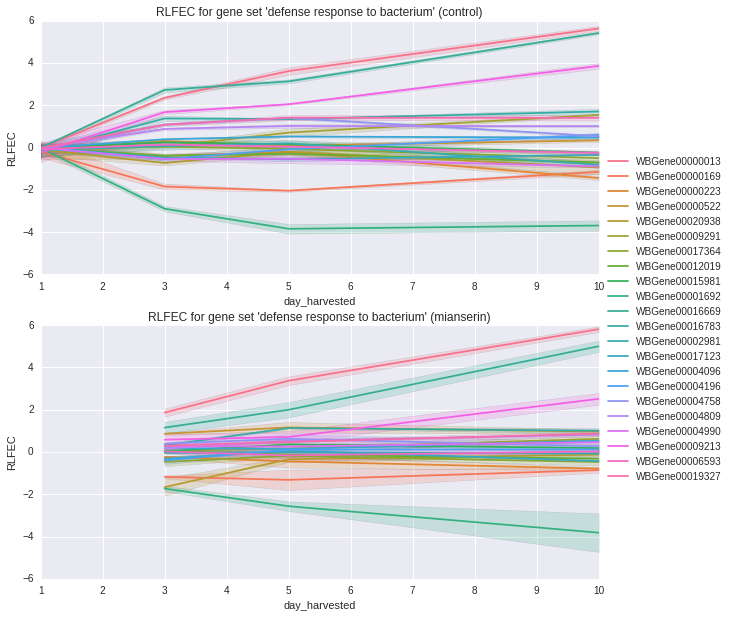

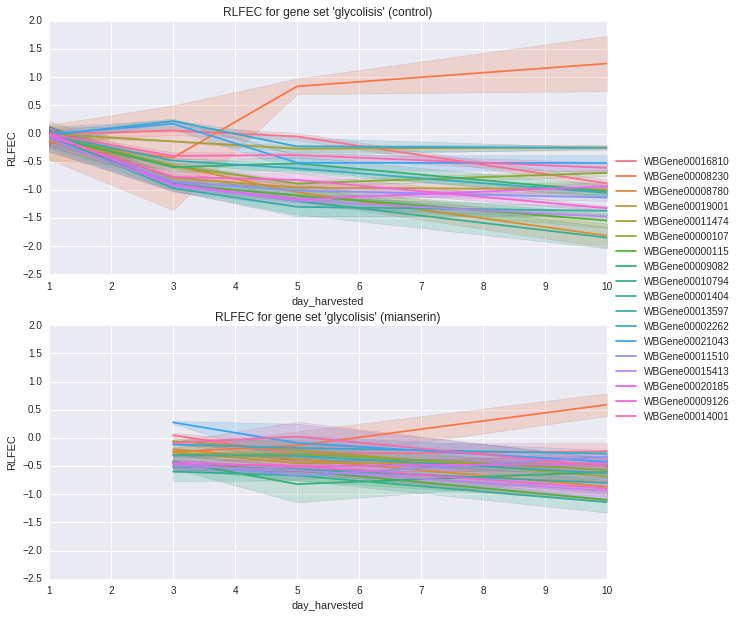

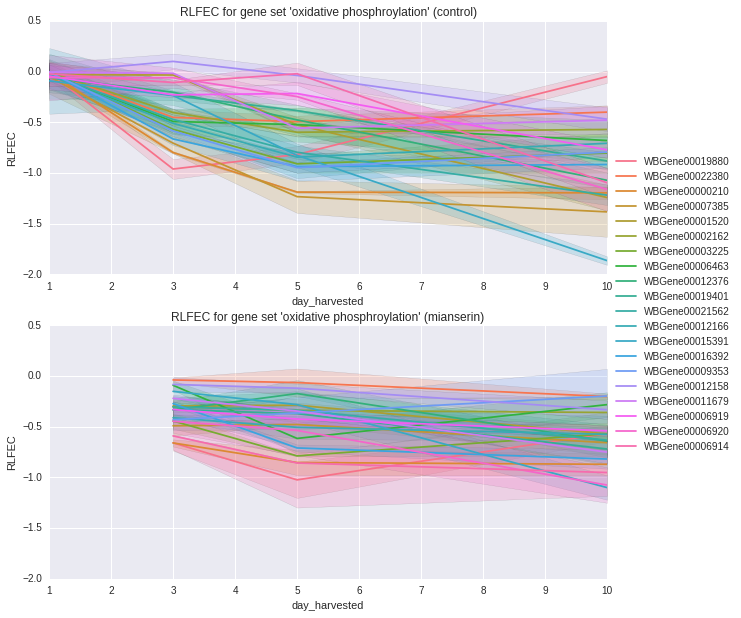

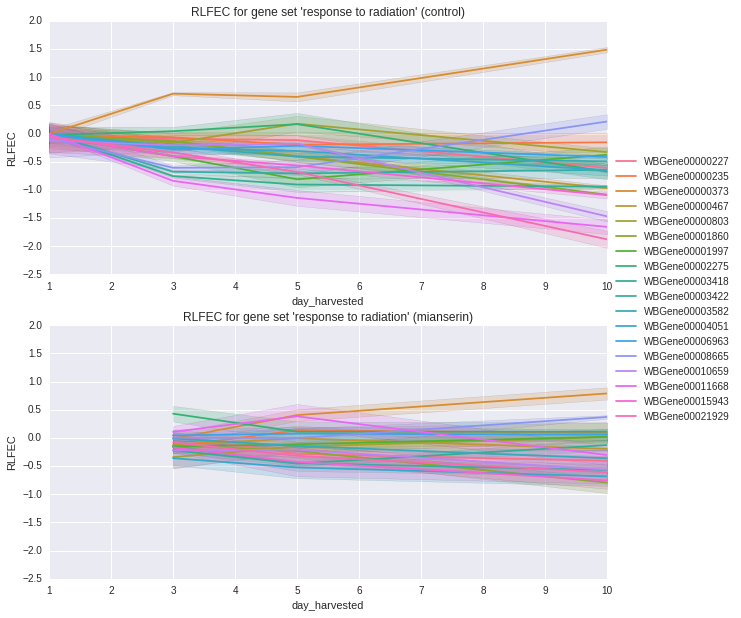

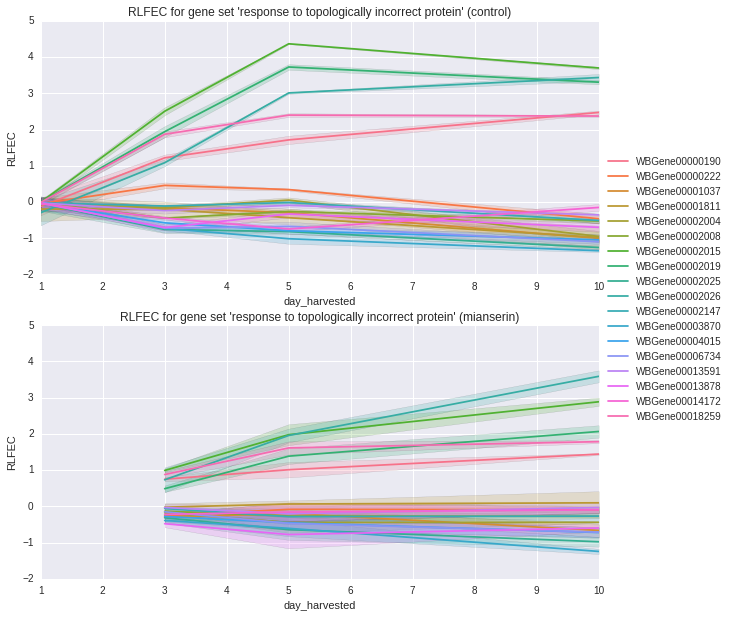

In [34]:
for name, df in tqdm(seq_sets.groupby("set_name")):
    sub = df.merge(exp, how = "left", on = "wormbase_id")
    
    summary(
        name, sub, "day_harvested", "replicate", "RLFEC", "wormbase_id"
    )